# Step 2: Build and train a GRU RNN model to learn the features of simulated crop data

*   Data import and visualization
*   Build a GRU RNN model to capture the features of simulated crop data, based on the DNDC dataset

# 1. Libraries and settings <a class="anchor" id="1-bullet"></a>

In [93]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import tensorflow as tf
import os
from google.colab import drive

print(os.getcwd())
drive.mount('/content/drive')  # revise according to your working directory

/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Analyze data <a class="anchor" id="2-bullet"></a>
- load data
- pre-process data
- visualize data

In [94]:
# load data file
df = pd.read_csv('/content/drive/MyDrive/INF_RP_CropModel/data_tomato_95cases_train.csv', header=0)
print(df.head())

   Unnamed: 0  Day  Temperature(C)  Humidity(percent)  Radiation(MJ/m2/d)  \
0           0   60            4.65               60.0               11.17   
1           1   61            6.20               60.0               12.53   
2           2   62            4.85               60.0               12.74   
3           3   63            4.15               60.0               12.95   
4           4   64            2.55               60.0               13.17   

   CO2(ppm)  Photosynthesis rate(kg C/ha/day)  \
0     300.0                               0.0   
1     300.0                               0.0   
2     300.0                               0.0   
3     300.0                               0.0   
4     300.0                               0.0   

   Root respiration rate(kg C/ha/day)  LAI  \
0                                 0.0  0.0   
1                                 0.0  0.0   
2                                 0.0  0.0   
3                                 0.0  0.0   
4           

In [95]:
# pre-process data
df = df.drop(columns="Unnamed: 0")
# df.Day = df.Day+738156-1  # 738156 = 2022-01-01
# df.Day = df.Day.apply(dt.datetime.fromordinal)
# df.Day = pd.to_datetime(df.Day, format='%Y-%m-%d')
df = df.set_index("Day")

In [96]:
print(df.head())

     Temperature(C)  Humidity(percent)  Radiation(MJ/m2/d)  CO2(ppm)  \
Day                                                                    
60             4.65               60.0               11.17     300.0   
61             6.20               60.0               12.53     300.0   
62             4.85               60.0               12.74     300.0   
63             4.15               60.0               12.95     300.0   
64             2.55               60.0               13.17     300.0   

     Photosynthesis rate(kg C/ha/day)  Root respiration rate(kg C/ha/day)  \
Day                                                                         
60                                0.0                                 0.0   
61                                0.0                                 0.0   
62                                0.0                                 0.0   
63                                0.0                                 0.0   
64                               

In [ ]:
# visualize data
labels_climate = ['Temperature(C)', 'Humidity(percent)', 'Radiation(MJ/m2/d)', 'CO2(ppm)']

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
for label in ['Photosynthesis rate(kg C/ha/day)', 'Root respiration rate(kg C/ha/day)', 'Shoot respiration rate(kg C/ha/day)']:
    plt.plot(df[label][:120], label=label)
plt.title('Tomato Growth')
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend(loc='best')

plt.subplot(3,1,2)
plt.plot(df['LAI'][:120], label='LAI')
plt.title('Tomato LAI')
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend(loc='best')

plt.subplot(3,1,3)
for label in labels_climate:
    plt.plot(df[label][:120], label=label)
plt.title('Climate')
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend(loc='best')

plt.show()

# 3. Manipulate data <a class="anchor" id="3-bullet"></a>
- normalize data
- create train and test data sets

In [98]:
# min-max normalization of df, column by column
df_norm = df.copy()
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
for column in df_norm.columns.tolist():
    df_norm[column] = scaler.fit_transform(df[column].values.reshape(-1,1))

In [99]:
# set test_percentage
test_percentage = 20

# set sequence length
seq_len = 10

# function to create train, validation, test data given data and sequence length
def load_data(input_data):
    data_raw = input_data.to_numpy() # convert to numpy array
    data = []
    # create all sequences of length seq_len
    for i in range(len(data_raw) - seq_len):
        data.append(data_raw[i: i + seq_len])
    data = np.array(data)
    test_size = int(np.round(test_percentage/100 * data.shape[0]))
    train_size = data.shape[0] - test_size
    x_train = data[:train_size,:-1,:]
    y_train = data[:train_size,-1,:]
    x_test = data[train_size:,:-1,:]
    y_test = data[train_size:,-1,:]
    return [x_train, y_train, x_test, y_test, train_size]

# split data to train/test sets
x_train, y_train, x_test, y_test, train_size = load_data(df_norm)

print(len(df_norm), len(df_norm) - seq_len, train_size)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

11742 11732 9386
x_train.shape =  (9386, 9, 8)
y_train.shape =  (9386, 8)
x_test.shape =  (2346, 9, 8)
y_test.shape =  (2346, 8)


# 4. RNN-GRU Model training and prediction <a class="anchor" id="4-bullet"></a>


In [100]:
# Create model
model = tf.keras.models.Sequential()
# Specify input shape
model.add(tf.keras.Input(shape=(x_train.shape[1],x_train.shape[2])))
# The GRU Layers
model.add(tf.keras.layers.GRU(units=256, return_sequences=True, activation='tanh'))
model.add(tf.keras.layers.GRU(units=128, return_sequences=True, activation='tanh'))
model.add(tf.keras.layers.GRU(units=64, return_sequences=True, activation='tanh'))
model.add(tf.keras.layers.GRU(units=16, return_sequences=False, activation='tanh'))
# The connection
model.add(tf.keras.layers.Dense(units=16))
# The output layer
model.add(tf.keras.layers.Dense(units=8))  # the output data have 8 columns
# Compile model
model.compile(optimizer='adam', loss='mean_absolute_error')
# Callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, start_from_epoch=20)
# Fit model on The Train and Validation Dataset
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=50, callbacks=[callback])

Epoch 1/50
74/74 [==============================] - 24s 171ms/step - loss: 0.1116 - val_loss: 0.0969
Epoch 2/50
74/74 [==============================] - 9s 127ms/step - loss: 0.0693 - val_loss: 0.0817
Epoch 3/50
74/74 [==============================] - 11s 151ms/step - loss: 0.0597 - val_loss: 0.0752
Epoch 4/50
74/74 [==============================] - 11s 144ms/step - loss: 0.0554 - val_loss: 0.0669
Epoch 5/50
74/74 [==============================] - 9s 125ms/step - loss: 0.0512 - val_loss: 0.0669
Epoch 6/50
74/74 [==============================] - 12s 159ms/step - loss: 0.0486 - val_loss: 0.0630
Epoch 7/50
74/74 [==============================] - 12s 157ms/step - loss: 0.0461 - val_loss: 0.0574
Epoch 8/50
74/74 [==============================] - 10s 134ms/step - loss: 0.0453 - val_loss: 0.0588
Epoch 9/50
74/74 [==============================] - 11s 153ms/step - loss: 0.0438 - val_loss: 0.0558
Epoch 10/50
74/74 [==============================] - 11s 153ms/step - loss: 0.0423 - val_loss

In [101]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 9, 256)            204288    
                                                                 
 gru_5 (GRU)                 (None, 9, 128)            148224    
                                                                 
 gru_6 (GRU)                 (None, 9, 64)             37248     
                                                                 
 gru_7 (GRU)                 (None, 16)                3936      
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
Total params: 394104 (1.50 MB)
Trainable params: 39410

<Axes: xlabel='epoch'>

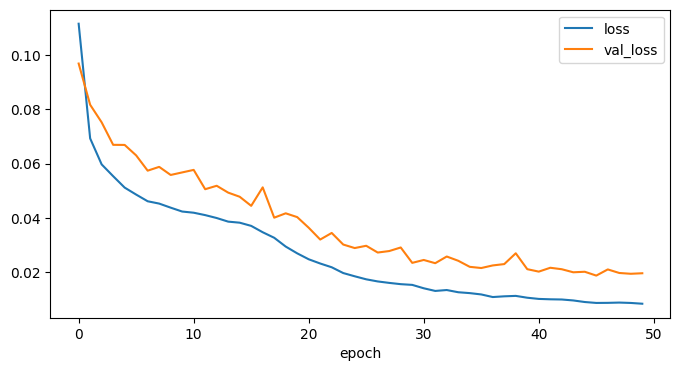

In [102]:
history_df = pd.DataFrame(history.history)
history_df.plot(figsize=(8,4), xlabel='epoch')

In [103]:
# Get predicted value from x_test
prediction = model.predict(x_test)
print(prediction.shape)

74/74 [==============================] - 3s 18ms/step
(2346, 8)


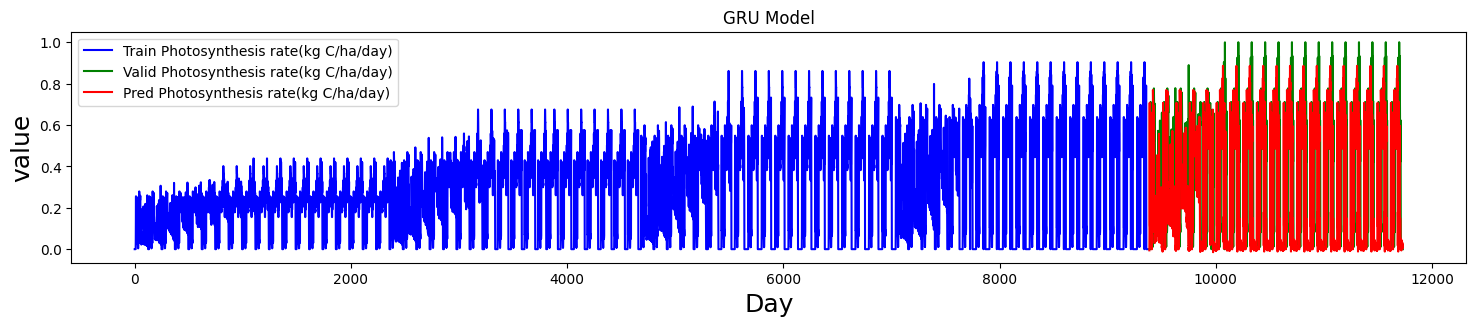

For the prediction of Photosynthesis rate(kg C/ha/day):
Mean Absolute Error: 0.01687829751525321
R2_Score: 0.9956407491470646


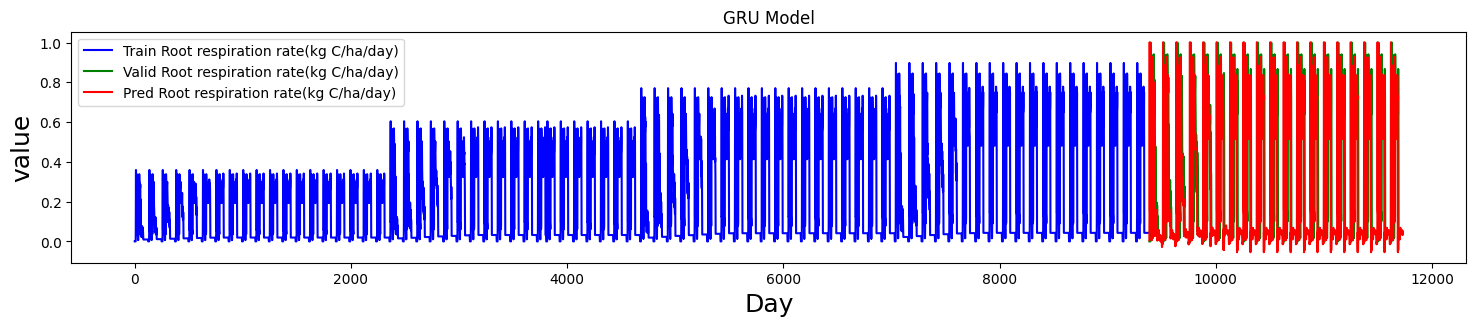

For the prediction of Root respiration rate(kg C/ha/day):
Mean Absolute Error: 0.007574226350275843
R2_Score: 0.9985822338610709


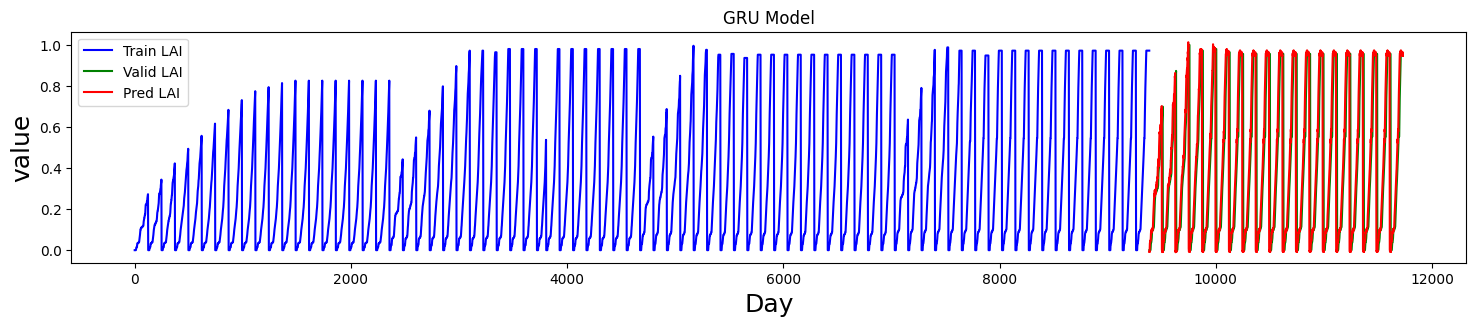

For the prediction of LAI:
Mean Absolute Error: 0.009594887679110292
R2_Score: 0.9982285635109537


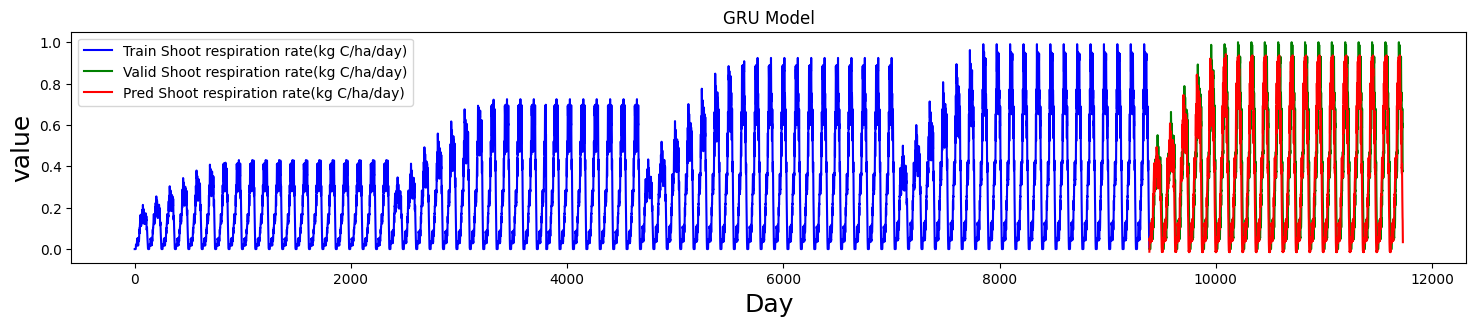

For the prediction of Shoot respiration rate(kg C/ha/day):
Mean Absolute Error: 0.010859699653462939
R2_Score: 0.9979151553595424


In [104]:
labels = ['Photosynthesis rate(kg C/ha/day)', 'Root respiration rate(kg C/ha/day)', 'LAI', 'Shoot respiration rate(kg C/ha/day)']

# Create train and validation data for plotting
train = df_norm[:train_size]
valid = df_norm[train_size: len(df) - seq_len]

# Visualizing the data and calculate metrics
for i in range(len(labels)):
    plt.figure(num=i, figsize=(18,3))
    plt.plot(np.arange(train_size), train[labels[i]][:train_size], color='blue', label='Train '+labels[i])
    plt.plot(np.arange(train_size, len(df_norm) - seq_len), valid[labels[i]], color='green', label='Valid '+labels[i])
    plt.plot(np.arange(train_size, len(df_norm) - seq_len), prediction[:, i+4], color='red', label='Pred '+labels[i])
    plt.title('GRU Model')
    plt.xlabel('Day', fontsize=18)
    plt.ylabel('value', fontsize=18)
    plt.legend(loc='best')
    plt.show()
    print(f'For the prediction of {labels[i]}:')
    print(f'Mean Absolute Error: {metrics.mean_absolute_error(y_test[i+4], prediction[i+4])}')
    # print(f'Mean Squared Error: {metrics.mean_squared_error(y_test[i+4], prediction[i+4])}')
    # print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test[i+4], prediction[i+4]))}')
    print(f'R2_Score: {metrics.r2_score(y_test[i+4], prediction[i+4])}')

In [ ]:
# save the model
model.save('/content/drive/MyDrive/INF_RP_CropModel/GRU_model_yuyanyang.keras')  # change path according to your directory